In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import json
import imageio
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import copy
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import StratifiedKFold

%run ../Scripts/trajectory.py
%run ../Scripts/trajectoryVisual.py
%run ../Scripts/trajsTree.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py

foldername = "../Data/test3/"

In [9]:
with open(foldername + "params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "sim_params.json") as json_file:
    sim_params = json.load(json_file)

In [10]:
t_start = 300
t_end = sim_params["tf"]
timestep = 25
t_domain = np.arange(t_start, t_end, timestep)

In [ ]:
n_i = scipy.sparse.load_npz(foldername+f"sp_frame_n{t_start}.npz").todok()
indexes = get_nonzero_w_repeats(n_i)
means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes, w = 1000)
# means0, covs0, counts0 = reduce_GMM(means_gmm, covs_gmm, counts_gmm)

# root = TreeNode(0, np.zeros(2), np.zeros((2,2)), 0)
# list_start_nodes = [TreeNode(frame, m, c, co) 
#                    for m, c, co in zip(means0, covs0, counts0)]

# for node in list_start_nodes:
#     root.add_child(node)

In [98]:
means1, covs1, counts1 = means0, covs0, counts0
list_next_nodes = list_start_nodes

for frame in t_domain[1:]:
    list_current_nodes = list_next_nodes

    n_i = scipy.sparse.load_npz(foldername+f"sp_frame_n{frame}.npz").todok()
    indexes = get_nonzero_w_repeats(n_i)
    
    means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes, w = 1000)
    means2, covs2, counts2 = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
    list_next_nodes = [TreeNode(frame, m, c, co)
                       for m, c, co in zip(means2, covs2, counts2)]

    link_list = find_links(means1, covs1, means2)

    for i, to_join in enumerate(link_list):
        for j in to_join:
            list_current_nodes[i].add_child(list_next_nodes[j])

    means1, covs1, counts1 = means2, covs2, counts2

root.save_tree("test3Tree2.json")

In [73]:
longest_chain = find_longest_chain(root)
longest_chain = longest_chain[1:] #pop the root

Text(0.5, 1.0, 'Trajectories of Longest Chains')

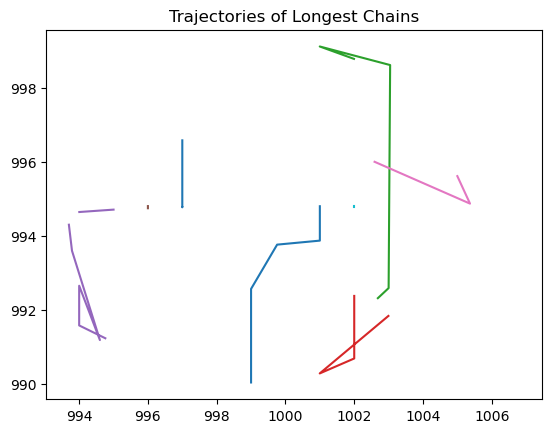

In [101]:
for child_node in root.children:
    longest_chain = find_longest_chain(child_node)
    x = np.zeros(len(longest_chain))
    y = np.zeros(len(longest_chain))
    time = np.zeros(len(longest_chain))
    N = np.zeros(len(longest_chain))

    for i, node in enumerate(longest_chain):
        x[i] = node.mean[0]
        y[i] = node.mean[1]
        time[i] = node.frame

        N[i] = node.count
    plt.plot(x, y)
plt.title("Trajectories of Longest Chains")

In [99]:
longest_chain = find_longest_chain(root)
longest_chain = longest_chain[1:] #pop the root

x = np.zeros(len(longest_chain))
y = np.zeros(len(longest_chain))
time = np.zeros(len(longest_chain))
N = np.zeros(len(longest_chain))

for i, node in enumerate(longest_chain):
    x[i] = node.mean[0]
    y[i] = node.mean[1]
    time[i] = node.frame

    N[i] = node.count

In [87]:
def calculate_velocity(N, params):
    R0 = params["R0"]
    M = params["M"]
    r = params["r"]
    v0 = 0
    sigma = 0

    D = calc_diff_const(params, sim_params)
    inv_v_tau = (np.power(R0, 1/M)-1)/r
    s = M*inv_v_tau

    common_log = 24*np.log(N*np.power(D*np.power(s,2), 1/3))
    v = np.power(s, 1/3)*np.power(D, 2/3)*np.power(common_log, 1/3)
    return v

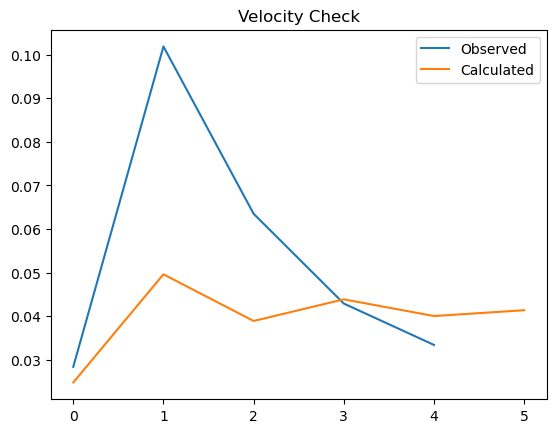

In [100]:
dt = 25
v_obs = np.sqrt(np.diff(x)**2 + np.diff(y)**2)/dt
v_calc = calculate_velocity(N, params)

plt.plot(v_obs, label = "Observed")
plt.plot(v_calc, label = "Calculated")
plt.title("Velocity Check")
plt.legend()